<img width = 85% src='rapids_motivation.png'>

<img width = 75% src='choices.png'>

### Overview 
1 -- load the dataset [ classification ]
Has categorical columns converted to ordinal and target variable "Arrival Delay" converted to binary target.

Dimensions: 115M rows, 13 columns.
Task: Binary classification
2 -- go through a data science pipeline [ pre-processing , splitting , viz ]

3 -- model building [ xgboost ]
> hyper-parameters [ max-depth, nTrees, learning rate, regularization ... ]

> demonstrate performance [ CPU vs 1 GPU ]

4 -- scaling and hyper-parameter search
> dask + rapids [ xgboost ]
    
5 -- visualize search and reveal best model parameters

TODO - generate figures that caputre benefit of GPU scaling

6 -- extensions[ multi-node [ dask kubernetes ], dask_xgboost [ larger dataset ] ]

In [1]:
import os
import sys
from enum import Enum

if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve  # pylint: disable=import-error,no-name-in-module
else:
    from urllib import urlretrieve  # pylint: disable=import-error,no-name-in-module

class LearningTask(Enum):
    REGRESSION = 1
    CLASSIFICATION = 2
    MULTICLASS_CLASSIFICATION = 3

class Data:  # pylint: disable=too-few-public-methods,too-many-arguments
    def __init__(self, X_train, X_test, y_train, y_test, learning_task, qid_train=None,
                 qid_test=None):
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test
        self.learning_task = learning_task
        # For ranking task
        self.qid_train = qid_train
        self.qid_test = qid_test
 
      
        

In [2]:
import pickle
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np; import numpy.matlib


In [3]:
import ipyvolume as ipv

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [5]:
# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
import cupy
import cudf

In [7]:
import time

In [8]:
import rapids_lib_v10 as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
      1. refresh/reload via the code below, OR
      2. restart the kernel '''
import importlib; importlib.reload(rl)

<module 'rapids_lib_v10' from '/rapids/notebooks/HPO_realdata/rapids_lib_v10.py'>

# Data Loading

In [9]:
def prepare_airline(dataset_folder, nrows):  # pylint: disable=too-many-locals
    url = 'http://kt.ijs.si/elena_ikonomovska/datasets/airline/airline_14col.data.bz2'
    local_url = os.path.join(dataset_folder, os.path.basename(url))
    pickle_url = os.path.join(dataset_folder,
                              "airline"
                              + ("" if nrows is None else "-" + str(nrows)) + ".pkl")
    if os.path.exists(pickle_url):
        return pickle.load(open(pickle_url, "rb"))
    if not os.path.isfile(local_url):
        urlretrieve(url, local_url)

    cols = [
        "Year", "Month", "DayofMonth", "DayofWeek", "CRSDepTime",
        "CRSArrTime", "UniqueCarrier", "FlightNum", "ActualElapsedTime",
        "Origin", "Dest", "Distance", "Diverted", "ArrDelay"
    ]

    # load the data as int16
    dtype = np.int16

    dtype_columns = {
        "Year": dtype, "Month": dtype, "DayofMonth": dtype, "DayofWeek": dtype,
        "CRSDepTime": dtype, "CRSArrTime": dtype, "FlightNum": dtype,
        "ActualElapsedTime": dtype, "Distance":
            dtype,
        "Diverted": dtype, "ArrDelay": dtype,
    }

    df =pd.read_csv(local_url,
                     names=cols, dtype=dtype_columns, nrows=nrows)

    # Encode categoricals as numeric
    for col in df.select_dtypes(['object']).columns:
        df[col] = df[col].astype("category").cat.codes

    # Turn into binary classification problem
    df["ArrDelayBinary"] = 1 * (df["ArrDelay"] > 0)

    X = df[df.columns.difference(["ArrDelay", "ArrDelayBinary"])]
    y = df["ArrDelayBinary"]
    del df
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=77,
                                                        test_size=0.2,
                                                        )
    data = Data(X_train, X_test, y_train, y_test, LearningTask.CLASSIFICATION)
    pickle.dump(data, open(pickle_url, "wb"), protocol=4)
    return data



In [10]:
num_rows = 40000000
higgs_df = prepare_airline(".", nrows= num_rows)

In [11]:
print(sys.getsizeof(higgs_df))

56


In [12]:
trainData_pDF = higgs_df.X_train
testData_pDF = higgs_df.X_test
trainLabels_pDF = higgs_df.y_train.to_frame()
testLabels_pDF = higgs_df.y_test.to_frame()

In [13]:
trainData_cDF = cudf.DataFrame.from_pandas(trainData_pDF)
testData_cDF = cudf.DataFrame.from_pandas(testData_pDF)
trainLabels_cDF = cudf.DataFrame.from_pandas(trainLabels_pDF)
testLabels_cDF = cudf.DataFrame.from_pandas(testLabels_pDF)

# Split train and test data 

In [14]:
expLog = {}

# Training and Evaluating a Single Model on CPU and GPU

In [15]:
''' -------------------------------------------------------------------------
>  GPU Train and Test
------------------------------------------------------------------------- '''
def train_model_GPU (trainData_cDF, testData_cDF, paramsGPU = {}):    
    print('training xgboost model on GPU');  
    startTime = time.time()    
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())    
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, params = paramsGPU, num_boost_round = paramsGPU['num_boost_rounds'] )
    
    return trainedModelGPU, time.time() - startTime

def test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on GPU')
    startTime = time.time()   
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())    
    predictionsGPU = trainedModelGPU.predict(testDMatrix)
    
    return predictionsGPU, time.time() - startTime

''' -------------------------------------------------------------------------
>  CPU Train and Test
------------------------------------------------------------------------- '''
def train_model_CPU (trainData_cDF, trainLabels_cDF, paramsCPU = {}):    
    print('training xgboost model on {} CPU cores'.format(nCores) )

    startTime = time.time()
    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())
    
    xgBoostModelCPU = xgboost.train( dtrain = trainDMatrix, params = paramsCPU, num_boost_round = paramsCPU['num_boost_rounds'])
    
    return xgBoostModelCPU, time.time() - startTime

def test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF ):
    print('testing xgboost model on CPU')
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( testData_cDF.to_pandas(), label = testLabels_cDF.to_pandas())
    predictionsCPU = trainedModelCPU.predict(testDMatrix)
    
    return predictionsCPU, time.time() - startTime

### Define model parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

In [16]:
nCores = !nproc --all
nCores = int(nCores[0])

paramsCPU = {
    'max_depth': 3,
    'num_boost_rounds': 100,    
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'hist',
    'n_jobs': nCores,
    'random_state': 0
}

paramsGPU = {
    'max_depth': 3,
    'num_boost_rounds': 100,
    'learning_rate': .1,
    'lambda': 1,    
    'objective': 'binary:hinge',
    'tree_method': 'gpu_hist',
    'n_gpus': 1,    
    'random_state': 0
}

### **CPU** Training and Inference

In [17]:
trainedModelCPU, t_trainCPU = train_model_CPU ( trainData_cDF, trainLabels_cDF, paramsCPU )

training xgboost model on 40 CPU cores


In [18]:
predictionsCPU, t_inferCPU = test_model_CPU ( trainedModelCPU, testData_cDF, testLabels_cDF)

testing xgboost model on CPU


In [19]:
expLog = rl.update_log( expLog, [['CPU_model_training', t_trainCPU], ['CPU_model_inference', t_inferCPU]] ); 

 + adding log entry [ CPU_model_training       :  99.90160 s ]
 + adding log entry [ CPU_model_inference      :   4.70468 s ]


### **GPU** Model Training and Inference

In [20]:
trainedModelGPU, t_trainGPU = train_model_GPU ( trainData_cDF, trainLabels_cDF, paramsGPU )

training xgboost model on GPU


In [21]:
predictionsGPU, t_inferGPU = test_model_GPU ( trainedModelGPU, testData_cDF, testLabels_cDF)

testing xgboost model on GPU


In [22]:
expLog = rl.update_log( expLog, [['GPU_model_training', t_trainGPU], ['GPU_model_inference', t_inferGPU]] ); 

 + adding log entry [ GPU_model_training       :  16.99448 s ]
 + adding log entry [ GPU_model_inference      :   3.04890 s ]


In [23]:
type(expLog)

dict

### Compare CPU and GPU Accuracy [ plot on train and test ]

In [24]:
trainLabels_pDF = trainLabels_cDF.to_pandas()
testLabels_pDF = testLabels_cDF.to_pandas()

trainPredictionsCPU, _ = test_model_CPU ( trainedModelCPU, trainData_cDF, trainLabels_cDF)
trainPredictionsGPU, _ = test_model_GPU ( trainedModelGPU, trainData_cDF, trainLabels_cDF)
trainAccuracyCPU = accuracy_score(trainLabels_pDF, trainPredictionsCPU)
trainAccuracyGPU = accuracy_score(trainLabels_pDF, trainPredictionsGPU)
print( 'train data CPU accuracy = {}'.format( trainAccuracyCPU ) )
print( 'train data GPU accuracy = {}'.format( trainAccuracyGPU ) )

accuracyCPU = accuracy_score(testLabels_pDF, predictionsCPU)
accuracyGPU = accuracy_score(testLabels_pDF, predictionsGPU)
print( 'test data CPU accuracy = {}'.format( accuracyCPU ) )
print( 'test data GPU accuracy = {}'.format( accuracyGPU ) )

testing xgboost model on CPU
testing xgboost model on GPU
train data CPU accuracy = 0.6291755625
train data GPU accuracy = 0.6291755625
test data CPU accuracy = 0.62902575
test data GPU accuracy = 0.62902575


In [25]:
cMat = confusion_matrix(testLabels_pDF, predictionsGPU)
print(cMat)

[[1852659 2031666]
 [ 936128 3179547]]


### Visualize the first decision tree

CPU times: user 64.6 ms, sys: 360 ms, total: 424 ms
Wall time: 823 ms


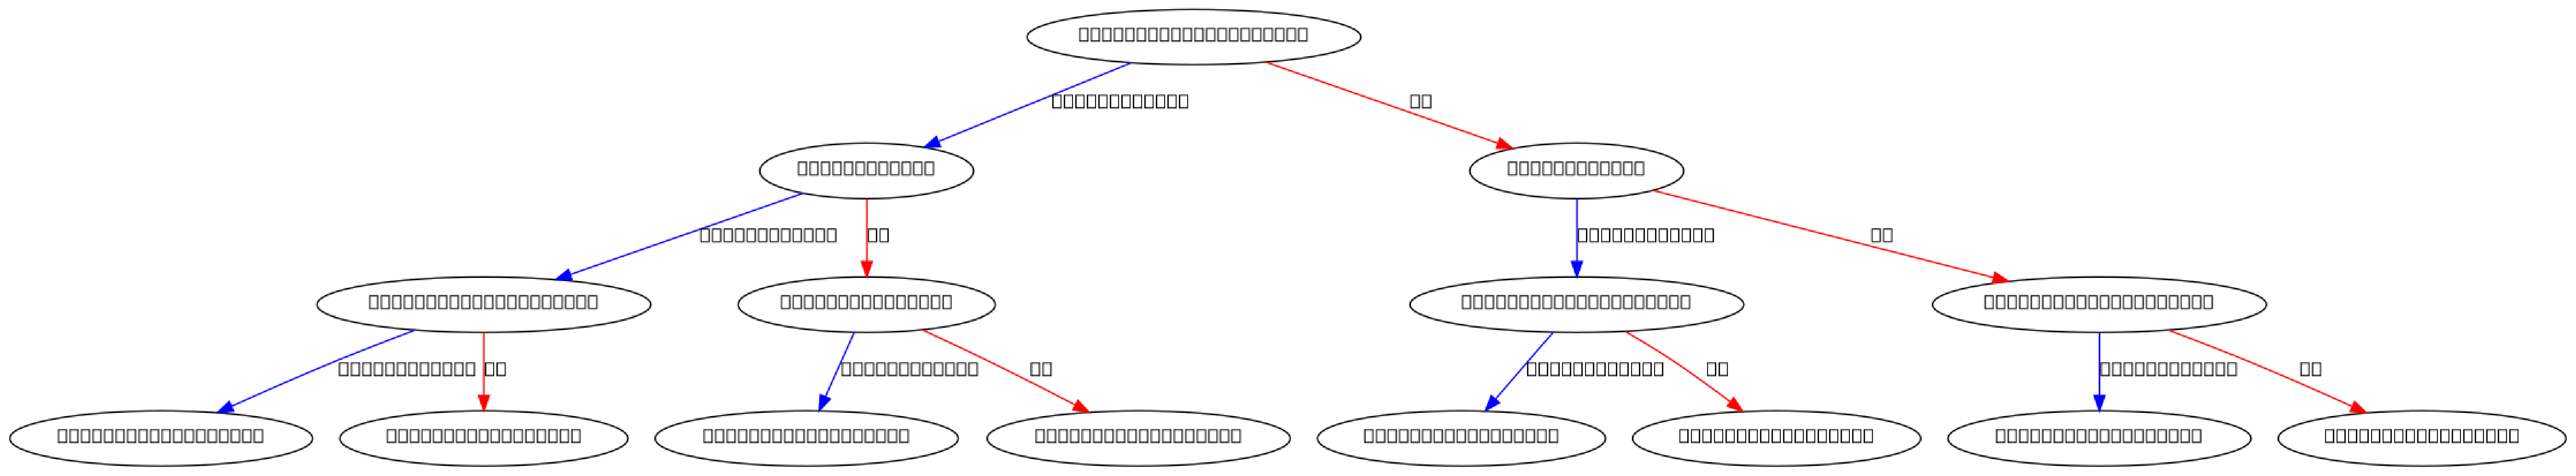

In [26]:
%%time
fig = plt.figure(figsize=(100,50))
plot_tree(trainedModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

In [27]:
expLog

{'CPU_model_training': 99.90159583091736,
 'CPU_model_inference': 4.704684734344482,
 'GPU_model_training': 16.99447751045227,
 'GPU_model_inference': 3.0489003658294678}

# Parameter Search          
> TODO: ADD early stopping 

### Initialize Dask

In [28]:
kube_ip = !echo $KUBEFLOW_CONTROLLER_SERVICE_HOST
if kube_ip[0]:
    dask_type = "k8s"
else:
    dask_type = "local"

In [29]:
# !pip install dask_kubernetes

In [30]:
import dask
from dask import delayed
from dask_cuda import LocalCUDACluster
from dask_kubernetes import KubeCluster
from dask.distributed import Client
from time import sleep # We need to give K8S some time to manually scale workers

In [31]:
import xgboost;
print( xgboost.__version__ )

0.90.rapidsdev1


#### Define the Kubernetes Dask Spec

In [32]:
worker_spec_fname = '/worker_spec.yaml'
worker_spec = '''
# worker-spec.yml

kind: Pod
metadata:
  labels:
    foo: bar
spec:
  restartPolicy: Never
  containers:
  - image: supertetelman/k8s-rapids-dask:0.9-cuda10.0-runtime-ubuntu18.04
    imagePullPolicy: IfNotPresent
    args: [dask-worker,  --nthreads, '1', --no-bokeh, --memory-limit, 6GB, --death-timeout, '60']
    name: dask
    resources:
      limits:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
      requests:
        cpu: "2"
        memory: 6G
        nvidia.com/gpu: 1
'''

with open(worker_spec_fname, "w") as yaml_file:
    yaml_file.write(worker_spec)

In [33]:
def scale_cluster(cluster, n, m=None):
    if dask_type != "k8s":
        print("Cannot scale non-K8S cluster")
        return
    if m is None:
        print(f'Scaling to {n} nodes')
        cluster.scale(n)
    else:
        print(f'Setting Scaling to adapatve, [{n}, {m}]')
        cluster.adapt(minimum = n, maximum = m)
    sleep(10)

### Set number of workers [ changes require kernel restart ]

In [34]:
if dask_type == "k8s":
    cluster = KubeCluster.from_yaml(worker_spec_fname)
    scale_cluster(cluster, 4)
else:
    cluster = LocalCUDACluster(ip="", n_workers = 4)

client = Client(cluster)

In [35]:

client

Client Scheduler: tcp://192.168.99.4:41431 Dashboard: http://192.168.99.4:8787/status,Cluster Workers: 4 Cores: 4 Memory: 270.39 GB


In [36]:
cluster

### Pre-scatter Demo

In [37]:
if client is not None:        
    scatteredData_future = client.scatter( [ trainData_cDF, testData_cDF, trainLabels_cDF,testLabels_cDF ], broadcast = True)

In [38]:
scatteredData_future

[<Future: status: finished, type: DataFrame, key: DataFrame-1d040d88c8715287965afed8cb407cf2>,
 <Future: status: finished, type: DataFrame, key: DataFrame-a508d28d029a9723a70dfdfdfa0de545>,
 <Future: status: finished, type: DataFrame, key: DataFrame-8ee5f22a0cd07ce55c278791b7cdb548>,
 <Future: status: finished, type: DataFrame, key: DataFrame-c74bd886c3f18ac476971fa8576da3e4>]

In [39]:
print ( '{} \n {} \n'.format( scatteredData_future[0].key, scatteredData_future[1].key ) )
client.who_has(scatteredData_future)

DataFrame-1d040d88c8715287965afed8cb407cf2 
 DataFrame-a508d28d029a9723a70dfdfdfa0de545 



{'DataFrame-1d040d88c8715287965afed8cb407cf2': ('tcp://192.168.99.4:39875',
  'tcp://192.168.99.4:45655',
  'tcp://192.168.99.4:45665',
  'tcp://192.168.99.4:42305'),
 'DataFrame-8ee5f22a0cd07ce55c278791b7cdb548': ('tcp://192.168.99.4:39875',
  'tcp://192.168.99.4:45655',
  'tcp://192.168.99.4:45665',
  'tcp://192.168.99.4:42305'),
 'DataFrame-c74bd886c3f18ac476971fa8576da3e4': ('tcp://192.168.99.4:39875',
  'tcp://192.168.99.4:45655',
  'tcp://192.168.99.4:45665',
  'tcp://192.168.99.4:42305'),
 'DataFrame-a508d28d029a9723a70dfdfdfa0de545': ('tcp://192.168.99.4:39875',
  'tcp://192.168.99.4:45655',
  'tcp://192.168.99.4:45665',
  'tcp://192.168.99.4:42305')}

## HPO Strategy - Particle Swarm [ Explore + Exploit ]

In [40]:
def update_particles( paramRanges, particlesInTimestep, velocitiesInTimestep, bestParamsIndex, globalBestParams, sBest = .85, sExplore = .1 , deltaTime = 1, randomSeed = None):
    
    nParticles = particlesInTimestep.shape[ 0 ]
    nParameters = particlesInTimestep.shape[ 1 ]    
        
    globalBestRepeated = numpy.matlib.repmat( np.array( globalBestParams ).reshape( -1, 1 ), nParticles, 1).reshape( nParticles, nParameters )    
    
    if randomSeed is not None:
        np.random.seed(randomSeed)
        
    # move to best + explore | globalBest + personalBest
    velocitiesInTimestep += 0. * velocitiesInTimestep + sBest * ( globalBestRepeated - particlesInTimestep ) \
                            + sExplore * ( np.random.randn( nParticles, nParameters ) )
    
    particlesInTimestep += velocitiesInTimestep * deltaTime 
    
    # TODO: avoid duplicates
    
    # enforce param bounds
    for iParam in range( nParameters ):
        particlesInTimestep[ :, iParam ] = np.clip(particlesInTimestep[ :, iParam ], paramRanges[iParam][1], paramRanges[iParam][2])
        if paramRanges[iParam][3] == 'int':
            particlesInTimestep[ :, iParam ] = np.round( particlesInTimestep[ :, iParam ] )
            
    return particlesInTimestep, velocitiesInTimestep
    

## HPO Harness
> Particle Evals [ Train and Test Logic ]

In [41]:
def train_model_hpo ( trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, particleParams, iParticle, iTimestep ):
    
    # fixed parameters
    paramsGPU = { 'objective': 'binary:hinge',
                  'tree_method': 'gpu_hist',
                  'n_gpus': 1,
                  'random_state': 0 }
    
    # parameters to search over
    paramsGPU['max_depth'] = int(particleParams[0])
    paramsGPU['learning_rate'] = particleParams[1]
    paramsGPU['lambda'] = particleParams[2]
    paramsGPU['num_boost_rounds'] = 1000
    
    startTime = time.time()
    trainDMatrix = xgboost.DMatrix( data = trainData_cDF, label = trainLabels_cDF )
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, evals = [(testDMatrix, 'test')], 
                                     params = paramsGPU,
                                     num_boost_round = paramsGPU['num_boost_rounds'],
                                     early_stopping_rounds = 15,
                                     verbose_eval = False )
    
    elapsedTime = time.time() - startTime
    
    return trainedModelGPU, elapsedTime

def test_model_hpo ( trainedModelGPU, trainingTime, testData_cDF, testLabels_cDF ):
    
    startTime = time.time()
    
    testDMatrix = xgboost.DMatrix( data = testData_cDF, label = testLabels_cDF )    
    predictionsGPU = trainedModelGPU.predict( testDMatrix ).astype(int)
    
    return predictionsGPU, trainedModelGPU.best_iteration, trainingTime, time.time() - startTime

In [42]:
def run_hpo ( daskClient, nTimesteps, nParticles, paramRanges, trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, randomSeed = 0, plotFlag = True):
    
    pandasTestLabels = testLabels_cDF.to_pandas()

    if daskClient is not None:
        scatteredData_future = daskClient.scatter( [ trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF ], broadcast = True )
    
    trainData_cDF_future = scatteredData_future[0]; trainLabels_cDF_future = scatteredData_future[1]
    testData_cDF_future = scatteredData_future[2]; testLabels_cDF_future = scatteredData_future[3]
    
    particles, velocities, accuracies, bestParticleIndex, \
        globalBestParticleParams, particleBoostingRounds, particleColors = rl.initialize_particle_swarm ( nTimesteps = nTimesteps, 
                                                                                                          nParticles = nParticles,
                                                                                                          paramRanges = paramRanges,
                                                                                                          randomSeed = randomSeed, 
                                                                                                          plotFlag = plotFlag)
    globalBestAccuracy = 0
    
    trainingTimes = np.zeros (( nTimesteps, nParticles ))    
    startTime = time.time()
    
    predictionHistory = np.zeros((nTimesteps, nParticles, testData_cDF.shape[0]))
    
    for iTimestep in range (0, nTimesteps ):    
        if daskClient is not None:
            # [ delayed ] train xgboost models on train data
            delayedParticleTrain = [ delayed( train_model_hpo )( trainData_cDF_future, trainLabels_cDF_future, 
                                                                     testData_cDF_future, testLabels_cDF_future, 
                                                                     particles[iTimestep, iParticle, : ], 
                                                                         iParticle, iTimestep) for iParticle in range(nParticles) ]

            # [ delayed ] determine number of trees/training-rounds returned early stopping -- used to set particle sizes
            delayedParticleRounds = [ iParticle[0].best_iteration for iParticle in delayedParticleTrain ]
            
            # [delayed ] eval trained models on test/validation data
            delayedParticlePredictions = [ delayed( test_model_hpo )(iParticle[0], iParticle[1], 
                                                                     testData_cDF_future, 
                                                                     testLabels_cDF_future) for iParticle in delayedParticleTrain ]
            
            # execute delayed             
            particlePredictions = dask.compute( delayedParticlePredictions )[0]            
            
            
            for iParticle in range(nParticles):
                predictionHistory[iTimestep, iParticle, :] = particlePredictions[iParticle][0]
            #import pdb; pdb.set_trace()
            
            # compute accuracies of predictions
            accuracies[iTimestep, :] = [ accuracy_score ( pandasTestLabels, iParticle[0]) for iParticle in particlePredictions ]
            particleBoostingRounds[iTimestep, : ] = [ iParticle[1] for iParticle in particlePredictions ]
            trainingTimes[iTimestep, :] = [ iParticle[2] for iParticle in particlePredictions ]
            del particlePredictions
        else:
            for iParticle in range(nParticles):
                trainedModels, _ = train_model_hpo ( pandasTrainData, pandasTrainLabels, particles[iTimestep, iParticle, : ], iParticle, iTimestep)
                predictions, _ = test_model_hpo( trainedModels, pandasTestData, pandasTestLabels)            
                accuracies[iTimestep, iParticle] = accuracy_score (pandasTestLabels, predictions)
        
        bestParticleIndex[iTimestep+1] = np.argmax( accuracies[iTimestep, :] )
        currentBestAccuracy = np.max( accuracies[iTimestep, :] )

        print('@ hpo timestep : {}, best accuracy is {}'.format(iTimestep, np.max(accuracies[iTimestep, :])) )
        if iTimestep +1 < nTimesteps:            
            if currentBestAccuracy > globalBestAccuracy:
                print('\t updating best GLOBAL accuracy')
                globalBestAccuracy = currentBestAccuracy
                globalBestParticleParams[iTimestep+1] = particles[iTimestep, bestParticleIndex[iTimestep+1], :]
            else:
                globalBestParticleParams[iTimestep+1] = globalBestParticleParams[iTimestep].copy()
            
            particles[iTimestep+1, :, :], velocities[iTimestep+1, :, : ] = update_particles ( paramRanges, 
                                                                                              particles[iTimestep, :, :].copy(),
                                                                                              velocities[iTimestep, :, :].copy(), 
                                                                                              bestParticleIndex[iTimestep+1], 
                                                                                              globalBestParticleParams[iTimestep+1], randomSeed = iTimestep)
            

    
    particleSizes = particleBoostingRounds/np.max(particleBoostingRounds)*10 + 2
    
    elapsedTime = time.time() - startTime
    
    bestParamIndex = np.unravel_index(np.argmax(accuracies, axis=None), accuracies.shape)

    # best accuracy
    print('highest accuracy               :  {} '.format(accuracies[bestParamIndex[0], bestParamIndex[1]]))
    print('   @ timestep {}, particle {} '.format( bestParamIndex[0], bestParamIndex[1]))

    print('\nbest model tree depth          :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 0]))
    print('best model learning rate       :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 1]))
    print('best model regularization      :  {} '.format(particles[bestParamIndex[0], bestParamIndex[1], 2]))
    print('best model num boosting rounds :  {} '.format(int(particleBoostingRounds[bestParamIndex[0], bestParamIndex[1]])))
    
    print( 'elapsed time : {}'.format(elapsedTime) )
    
    return accuracies, particles, velocities, particleSizes, particleColors, bestParticleIndex, bestParamIndex, particleBoostingRounds, trainingTimes, predictionHistory, elapsedTime

## Settings for HPO

In [43]:
nTimesteps = 1
nParticles = 16

In [44]:
paramRanges = { 0: ['max_depth', 3, 15, 'int'],
                1: ['learning_rate', .001, 1, 'float'],
                2: ['lambda', 0, 10, 'float'] }

### Run HPO

In [45]:
accuracies, particles, velocities, particleSizes, particleColors, bestParticleIndex, \
bestParamIndex, particleBoostingRounds, trainingTimes, predictionHistory, elapsedTime = run_hpo ( client, nTimesteps, 
                                                                                                  nParticles,
                                                                                                  paramRanges, 
                                                                                                  trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF )

distributed.nanny - WARNING - Restarting worker


@ hpo timestep : 0, best accuracy is 0.8471085
highest accuracy               :  0.8471085 
   @ timestep 0, particle 11 

best model tree depth          :  15.0 
best model learning rate       :  0.334 
best model regularization      :  10.0 
best model num boosting rounds :  480 
elapsed time : 674.3164970874786


### Visualize search

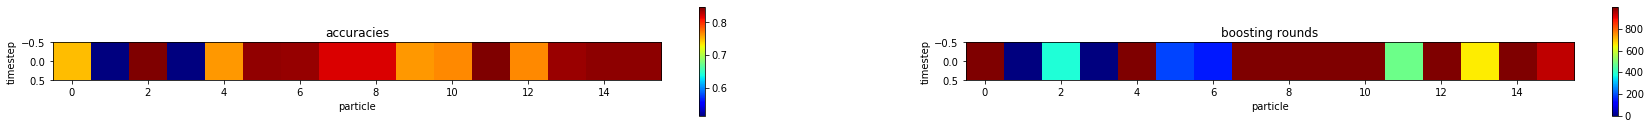

In [46]:
rl.viz_search( accuracies, particleBoostingRounds )

In [47]:
rl.hpo_animate (particles, particleSizes, particleColors, paramRanges, nTimesteps = nTimesteps )

## Appendix

In [48]:
# 1 -- use non-synthetic dataset
# 2 -- kubernetes